## Import packages

In [1]:
import kwant
print(kwant.version.version)
import numpy as np
import matplotlib.pyplot as plt

/Users/declanburke/opt/anaconda3/lib/python3.7/site-packages/kwant/solvers/default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


1.4.2


## Lattice properties

In [2]:
a = 10 # angstroms

norbs = 4 # 2 atomic orbitals * 2 spins * particle-hole

lat = kwant.lattice.cubic(a, norbs=8)
#chain (1D), cubic (3D), triangular, honeycomb, kagome
# print(lat)

## MTI Hamiltonian + discretization

In [3]:
import kwant.continuum

hamiltonian_MTI = ("{epsilon} * kron(sigma_0, sigma_0) + "
                  "{M} * kron(sigma_0, sigma_z) + "
                  "A_perp * k_x * kron(sigma_x, sigma_x) + "
                  "A_perp * k_y * kron(sigma_y, sigma_x) + "
                  "A_z * k_z * kron(sigma_z, sigma_x) + "
                  "m_z * kron(sigma_z, sigma_0)")


epsilon = "(0.0 - 0.0 * (k_x**2 + k_y**2) - 0.0 * k_z**2)"
M = "(0.3 - 15.0 * (k_x**2 + k_y**2) - 15.0 * k_z**2)"

hamiltonian_MTI = hamiltonian_MTI.format(epsilon=epsilon, M=M)
ham_MTI_discretized = kwant.continuum.discretize(hamiltonian_MTI, grid=a)

print('MTI Hamiltonian:',hamiltonian_MTI)

MTI Hamiltonian: (0.0 - 0.0 * (k_x**2 + k_y**2) - 0.0 * k_z**2) * kron(sigma_0, sigma_0) + (0.3 - 15.0 * (k_x**2 + k_y**2) - 15.0 * k_z**2) * kron(sigma_0, sigma_z) + A_perp * k_x * kron(sigma_x, sigma_x) + A_perp * k_y * kron(sigma_y, sigma_x) + A_z * k_z * kron(sigma_z, sigma_x) + m_z * kron(sigma_z, sigma_0)


## System creation

In [4]:
import numpy as np

tau_z = np.kron(np.kron(np.array([[1, 0], [0, -1]]), np.eye(2)), np.eye(2))

def make_system(L, W, H):
    syst = kwant.Builder()
    
    def syst_shape(site):
        (x, y, z) = site.pos
        return (0 <= x <= L and 0 <= y <= W and 0 <= z <= H)
    
    syst.fill(ham_MTI_discretized, syst_shape, (0, 0, 0))
    lead_left = kwant.Builder(kwant.TranslationalSymmetry((-a, 0, 0)))
    lead_right = kwant.Builder(kwant.TranslationalSymmetry((a, 0, 0)))
    

    
    def lead_shape(site):
        (x, y, z) = site.pos
        return (0 <= y <= W and 0 <= z <= H)
    
   
    lead_left.fill(ham_MTI_discretized, lead_shape, (0, 0, 0))
    lead_right.fill(ham_MTI_discretized, lead_shape, (L, 0, 0))
    
    syst.attach_lead(lead_left) # lead 0
    syst.attach_lead(lead_right) # lead 1
    
    return syst 

In [5]:
syst_L = 100
syst_W = 100
syst_H = 100
syst = make_system(syst_L, syst_W, syst_H)
systf = syst.finalized()

nleads = 2

/Users/declanburke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


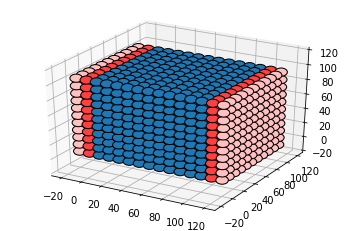

In [6]:
plot = kwant.plot(systf, show=False)
plot.show()

## Prameters

In [7]:
params_toyA_SC = dict(A_perp=3.0,
                      A_z=3.0,
                      M_0=0.3,
                      M_perp=15.0,
                      M_z=15.0,
                      C_0=0.0,
                      C_perp=.0,
                      C_z=0.0,
                      m_z= 0.03,
                     )

## Plot band structure

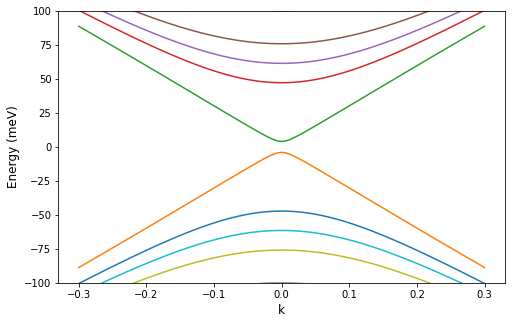

In [10]:
import matplotlib.pyplot as plt
bands=kwant.physics.Bands(systf.leads[1], params=params_toyA_SC)
momenta=np.linspace(-0.3,0.3,101)
energies=[bands(k) for k in momenta]

x=np.array(energies)
en=(x *1000)
plt.ylim(-100,100)


plt.plot(momenta, en)

plt.ylabel('Energy (meV)', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()

## Plot no of band crossings for positive k-value as a function of chemical potential and magnetsiation. Odd number required for QAHE/ Majorana's when proximitized

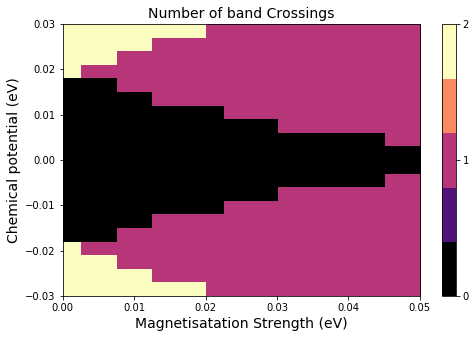

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

Bfields=np.linspace(0,0.05,20)
Vdata = []
energies = np.linspace(-0.05,0.05,25)
for e in energies:
    E_data=[]
    for B in Bfields:
        params_toyA_SC = dict(A_perp=3.0,
                      A_z=3.0,
                      M_0=0.3,
                      M_perp=15.0,
                      M_z=15.0,
                      C_0=0.0,
                      C_perp=.0,
                      C_z=0.0,
                      m_z= B,
                      M_WM= 0.0,
                      a=a,
                      phi_0=1.0,
                      exp=np.exp,
                      #B_x=.0,
                      #B_y=.0,
                      #B_z=.0,
                     )
        plt.rcParams["figure.figsize"]= (8,5)  
        mode_info = systf.leads[0].modes(energy=e, params=params_toyA_SC)
        #smatrix = kwant.smatrix(syst,  params = dict(m_z = B))
        E_data.append((mode_info[0].block_nmodes[0]))  
            
    Vdata.append(E_data)
     
cbar = mpl.cm.get_cmap("magma", 5)
            
plt.imshow(Vdata, aspect = 'auto',extent = [min(Bfields), max(Bfields), min(energies), max(energies)], cmap=cbar)
plt.xlabel("Magnetisatation Strength (eV)", fontsize=14)



#cbar.set_label("no of band crossings")
plt.ylabel("Chemical potential (eV)", fontsize=14)
plt.colorbar(ticks=np.linspace(0,4,5))
plt.title('Number of band Crossings', fontsize=14 )
plt.show()